<a href="https://colab.research.google.com/github/Aurora-Chaser/Axion_Nserc_Project_2025/blob/main/Axion_Stufff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cupy as cp
from scipy import integrate
from scipy.interpolate import CubicSpline
from cupyx.scipy.interpolate import make_interp_spline
import time

R = 40
Nr, Ntheta, Nphi = 4*2048 + 1, 2*64 + 1, 2*128 + 1

# Spherical grid
r = np.linspace(0, R, Nr)
theta = np.linspace(0, np.pi, Ntheta)
phi = np.linspace(0, 2*np.pi, Nphi)
dr, dtheta, dphi = r[1]-r[0], theta[1]-theta[0], phi[1]-phi[0]
R_grid, Theta_grid, Phi_grid = np.meshgrid(r, theta, phi, indexing='ij')

# Function and volume element
f = np.exp(-R_grid**2)*np.sin(15*R_grid)* (np.sin(Phi_grid)**2) * (1/np.sqrt(R_grid **2 + 10e-34)) * (R_grid**2 * np.sin(Theta_grid))
dV =  dr * dtheta * dphi

# =====================================================
# 1) Direct sum
t0 = time.time()
I_sum = np.sum(f )
t_sum = time.time() - t0

# =====================================================
# 2) Simpson's rule (CPU)
t0 = time.time()
int_phi = integrate.simpson(f, phi, axis=2)
int_theta = integrate.simpson(int_phi , theta, axis=1)
I_simp = integrate.simpson(int_theta , r)
t_simp = time.time() - t0

# =====================================================
# 3) tplquad (CPU, reference)
def integrand(phi, theta, rr):
    return np.exp(-rr**2) * np.sin(15*rr) * rr**2 * np.sin(theta) * (np.sin(phi)**2) * (1/np.sqrt(rr**2 + 10e-34))

t0 = time.time()
I_tplquad, err_tplquad = integrate.tplquad(
    integrand, 0, R,
    lambda rr: 0, lambda rr: np.pi,
    lambda rr, th: 0, lambda rr, th: 2*np.pi
)
t_tplquad = time.time() - t0
# =====================================================
t0 = time.time()


int_phi = integrate.romb(f, dx = dphi , axis=2)
int_theta = integrate.romb(int_phi , dx = dtheta, axis=1)
I_romb = integrate.romb(int_theta, dx = dr)
t_romb = time.time() - t0


# =====================================================
# 5) CuPy CubicSpline (GPU)
r_cp = cp.array(r)
theta_cp = cp.array(theta)
phi_cp = cp.array(phi)
R3_cp, Th3_cp, Ph3_cp = cp.meshgrid(r_cp, theta_cp, phi_cp, indexing='ij')
f3_cp = cp.exp(-R3_cp**2) * cp.sin(15*R3_cp) * R3_cp**2 * cp.sin(Th3_cp) * (cp.sin(Ph3_cp)**2) * (1/np.sqrt(R3_cp**2 + 10e-34))


# =====================================================
# 6) Trapezoidal method (CPU, full 3D)
t0 = time.time()
int_phi_trap = integrate.trapezoid(f, phi, axis=2)
int_theta_trap = integrate.trapezoid(int_phi_trap, theta, axis=1)
I_trap = integrate.trapezoid(int_theta_trap, r)
t_trap = time.time() - t0

# =====================================================


# 7) CuPy trapz method (GPU)
f_cp = cp.exp(-R3_cp**2) * cp.sin(15*R3_cp) * R3_cp**2 * cp.sin(Th3_cp) * (cp.sin(Ph3_cp)**2) * (1/np.sqrt(R3_cp**2 + 10e-34))

t0 = time.time()
int_phi_cp = cp.trapz(f_cp, phi_cp, axis=2)
int_theta_cp = cp.trapz(int_phi_cp , theta_cp, axis=1)
I_trap_cp = cp.trapz(int_theta_cp, r_cp)

t_trap_cp = time.time() - t0

# =====================================================
# Results
I_sum_val    = float(I_sum)
I_simp_val   = float(I_simp)
I_tplquad_val= float(I_tplquad)
I_trap_val   = float(I_trap)
I_romb_val   = float(I_romb)
I_trap_cp_val= cp.asnumpy(I_trap_cp).item()


print(f"Direct sum:         {I_sum_val  :.24f} in {t_sum:.6f}s")
print(f"Simpson 3×:         {I_simp_val  :.24f} in {t_simp:.6f}s")
print(f"Romberg:            {I_romb_val  :.24f} in {t_romb:.6f}s")
print(f"tplquad:            {I_tplquad_val  :.24f} ±{err_tplquad:.2e} in {t_tplquad:.6f}s")
print(f"Trapezoid (CPU):    {I_trap_val  :.24f} in {t_trap:.6f}s")
print(f"Trapezoid (GPU):    {I_trap_cp_val  :.24f} in {t_trap_cp:.6f}s")


Direct sum:         -0.000000000006259750450581 in 0.174727s
Simpson 3×:         -0.000000000000000008014373 in 2.434228s
Romberg:            -0.000000000000010035562901 in 1.374246s
tplquad:            0.000000000000000665991513 ±9.81e-10 in 0.996227s
Trapezoid (CPU):    -0.000000000000000003790133 in 2.108351s
Trapezoid (GPU):    -0.000000000000000010815715 in 1.170070s


In [ ]:
import numpy as np
import warnings

from scipy.integrate import quad
from scipy.special import genlaguerre, factorial, sph_harm, spherical_jn
from scipy.special import sph_harm_y as sph_harm
from scipy.interpolate import CubicSpline
from scipy.integrate import simpson as simps
from sympy.functions.special.spherical_harmonics import Ynm
from scipy.special import sph_harm as sph_harm


from scipy.special import sph_harm  # or sph_harm_y if migrating
import sympy as sp
from sympy.functions.special.spherical_harmonics import Ynm as sp_Ynm


from matplotlib import cm
import matplotlib.pyplot as plt

import cupy as cp
from cupyx.scipy.special import sph_harm as sph_harm_cp


import time

from joblib import Parallel, delayed


def R_nl_np(n, l, a0, r):
    r = cp.asnumpy(r)
    rho = 2 * r / (n * a0)
    # Associated Laguerre polynomial L^{2l+1}_{n-l-1}(rho)
    L = genlaguerre(n - l - 1, 2*l + 1)(rho)

    norm = np.sqrt((((2/(n*a0))**3) * factorial(n-l-1) )/(2*n*(factorial(n+l))))
    return cp.asarray(norm * rho**l * np.exp(-rho/2) * L)


def hydrogen_wf_np(n, l, m, a0, r, th, ph):

    n, l, m = int(n), int(l), int(m)
    R = R_nl_np(n, l, a0, r)

    Y = sph_harm_cp(m, l, ph, th)

    return R * Y


def compute_element(idx, jdx, basis, alpha, a_0, Vmat, vol_factor,
                    r_grid, th_grid, ph_grid, r_vals, th_vals, ph_vals):
    t0 = time.time()

    n, l, m = basis[idx][:3]
    n1, l1, m1 = basis[jdx][:3]

    H_update = {}

    if jdx == idx:
        diag = alpha * (1 - (alpha ** 2) / (2 * (n ** 2)))

    if jdx != idx:
        diag = 0

    psi1 = hydrogen_wf_np(n, l, m, a_0, r_grid, th_grid, ph_grid)
    psi2 = hydrogen_wf_np(n1, l1, m1, a_0, r_grid, th_grid, ph_grid)

    integrand = psi1 * Vmat * cp.conjugate(psi2) * vol_factor

    I_ph = cp.trapz(integrand, ph_vals, axis=2)
    I_th = cp.trapz(I_ph, th_vals, axis=1)
    I_r = diag + cp.trapz(I_th, r_vals)

    # Since H is Hermitian, update both [idx, jdx] and [jdx, idx]
    H_update[(idx, jdx)] = I_r
    H_update[(jdx, idx)] = I_r

    elapsed = time.time() - t0

    return H_update, elapsed

def compute_spectrum(n_max, alpha, m_disk, a, b, basis):
    a_0 = 1 / (alpha ** 2)
    N = len(basis)

    H = cp.zeros((N, N), dtype=complex)

    # Prepare potential and volume factor
    Vmat = - (alpha * m_disk) / cp.sqrt(r_grid**2 + (a + cp.sqrt(b**2 + (r_grid * cp.cos(th_grid))**2))**2 + 1e-34)
    Vmat = Vmat * cp.ones((Nr, Nth, Nph), dtype=Vmat.dtype)
    vol_factor = r_grid**2 * cp.sin(th_grid)

    # Build list of index pairs where jdx >= idx
    index_pairs = [(idx, jdx) for idx in range(N) for jdx in range(idx, N)]

    # Parallel execution
    results = Parallel(n_jobs=-1, backend='threading', verbose=5)(
        delayed(compute_element)(
            idx, jdx, basis, alpha, a_0, Vmat, vol_factor,
            r_grid, th_grid, ph_grid, r_vals, th_vals, ph_vals
        )
        for idx, jdx in index_pairs
    )

    # Fill H and time stats
    t_sum = cp.zeros((0))
    for H_update, elapsed in results:
        for (i, j), value in H_update.items():
            H[i, j] += value
        t_sum = cp.append(t_sum, elapsed)

    print(f"Average iteration time of {cp.mean(t_sum):.24f}")

    eigenvals, eigenvecs = cp.linalg.eigh(H)
    eigenvals, eigenvecs = cp.asnumpy(eigenvals), cp.asnumpy(eigenvecs)

    return  eigenvals, eigenvecs


def print_eigenstates(eigenvalues, eigenvectors, basis, tol, x):

    idx = np.argsort(eigenvalues)
    eigs_all = eigenvalues[idx]
    vecs_all = eigenvectors[:, idx]

    # Optionally truncate to first x eigenvalues
    if x is not None:
        eigs = eigs_all[:x]
        vecs = vecs_all[:, :x]
    else:
        eigs = eigs_all
        vecs = vecs_all

    # Group nearly degenerate eigenvalues
    groups = []
    current = [0]
    for i in range(1, len(eigs)):
        if abs(eigs[i] - eigs[current[-1]]) < tol:
            current.append(i)
        else:
            groups.append(current)
            current = [i]
    groups.append(current)

    # Print grouped states
    for grp in groups:
        E0 = eigs[grp[0]]
        print(f"\n=== Eigenvalue ≈ {E0:.6f} (group size = {len(grp)}) ===")
        for k in grp:
            coeffs = vecs[:, k]
            comps = []
            for i, c in enumerate(coeffs):
                if abs(c) > 1e-2:
                    n, l, m = basis[i]
                    n,l,m = int(n),int(l),int(m)
                    comps.append(f"{c.real:+.3f}{c.imag:+.3f}j|{n}{l}{m}>")
            print(" + ".join(comps))

def plot_splitting_vs_mdisk_dominant_n(basis, n_max, m_disk_values, fixed_alpha, a, b, max_levels, a_0):
    basis = cp.asnumpy(basis)
    energy_matrix = []
    dom_n_matrix = []  # store dominant n for each level set

    # Loop over m_disk values
    for m in m_disk_values:
        energies, eigvecs = compute_spectrum(n_max=n_max, alpha=fixed_alpha, m_disk=m, a=a, b=b, basis=basis)
        energies = cp.asnumpy(energies)
        eigvecs = cp.asnumpy(eigvecs)
        idx = np.argsort(energies)
        energies_sorted = energies[idx]
        eigvecs_sorted = eigvecs[:, idx]

        avail_levels = min(max_levels, energies_sorted.size)
        energies_trunc = energies_sorted[:avail_levels]
        eigvecs_trunc = eigvecs_sorted[:, :avail_levels]

        energy_matrix.append(energies_trunc)

        # compute dominant n for each eigenvector
        dom_n = []
        for j in range(avail_levels):
            coeffs = eigvecs_trunc[:, j]
            k = int(np.argmax(np.abs(coeffs)))
            n_val, _, _ = basis[k]
            dom_n.append(n_val)
        dom_n_matrix.append(dom_n)

        print(f'finished computing for disk of mass {m}')

    # Convert to arrays
    energy_matrix = np.array([np.pad(row, (0, int(max_levels - len(row))), constant_values=np.nan)
                              for row in energy_matrix])
    dom_n_matrix = np.array([row + [None]*int(max_levels - len(row)) for row in dom_n_matrix])

    # map unique n values to colors
    flat_ns = [n for row in dom_n_matrix for n in row if n is not None]
    unique_ns = np.unique(flat_ns)
    cmap = cm.get_cmap('hsv', len(unique_ns))
    color_map = {n: cmap(i) for i, n in enumerate(unique_ns)}

    # plotting
    num_param = len(m_disk_values)
    x_positions = np.arange(num_param)
    fig, ax = plt.subplots(figsize=(12, 6))

    plotted_labels = set()
    for i in range(num_param):
        energies = energy_matrix[i]
        ns = dom_n_matrix[i]
        if len(energies) == 0:
            continue

        for j in range(max_levels):
            E = energies[j]
            n_val = ns[j]

            rel_diff = np.log10(np.abs(E))

            color = color_map[n_val]
            label = f"n={n_val}" if n_val not in plotted_labels else None
            if label:
                plotted_labels.add(n_val)

            ax.hlines(rel_diff, i - 0.2, i + 0.2,
                      color=color, linewidth=0.5,
                      label=label)

    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"{val:.2e}" for val in m_disk_values], rotation=45)
    ax.set_xlabel("m_disk")
    ax.set_ylabel("log₂ |E|")
    ax.set_title(f"Log Relative Splitting vs m_disk (alpha={fixed_alpha:.5f})")
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    ax.legend(title='Dominant n')
    plt.tight_layout()
    plt.show()


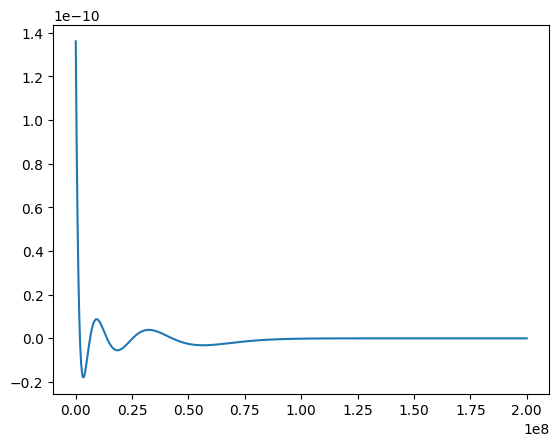

In [ ]:
alpha = 0.001

a = 10
b = 0.1

a_0 = 1/(alpha**2)

omega = cp.abs( (alpha ** 3) * (1/(2*36) - 1/(2*25)) )

L_max = 3

N_max = 6


Nr, Nth, Nph = 512, 90, 180
r_vals = cp.linspace(1e-24, 200*a_0, Nr)  # replace mu**2 with desired value or pass as parameter
th_vals = cp.linspace(1e-24, np.pi, Nth)
ph_vals = cp.linspace(1e-24, 2*np.pi, Nph)

r_grid = r_vals[:, None, None]
th_grid = th_vals[None, :, None]
ph_grid = ph_vals[None, None, :]

basis = cp.array([[n, l, m] for n in range(1, N_max + 1) for l in range(n) for m in range(-l, l + 1)],dtype=float)

plt.plot(cp.asnumpy(r_vals), cp.asnumpy(R_nl_np(N_max, 0, a_0, r_vals)))
plt.show()


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 4186 out of 41

Average iteration time of 0.135772110854275068758668
finished computing for disk of mass 0.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 4186 out of 41

Average iteration time of 0.136929068733958964054764
finished computing for disk of mass 0.1


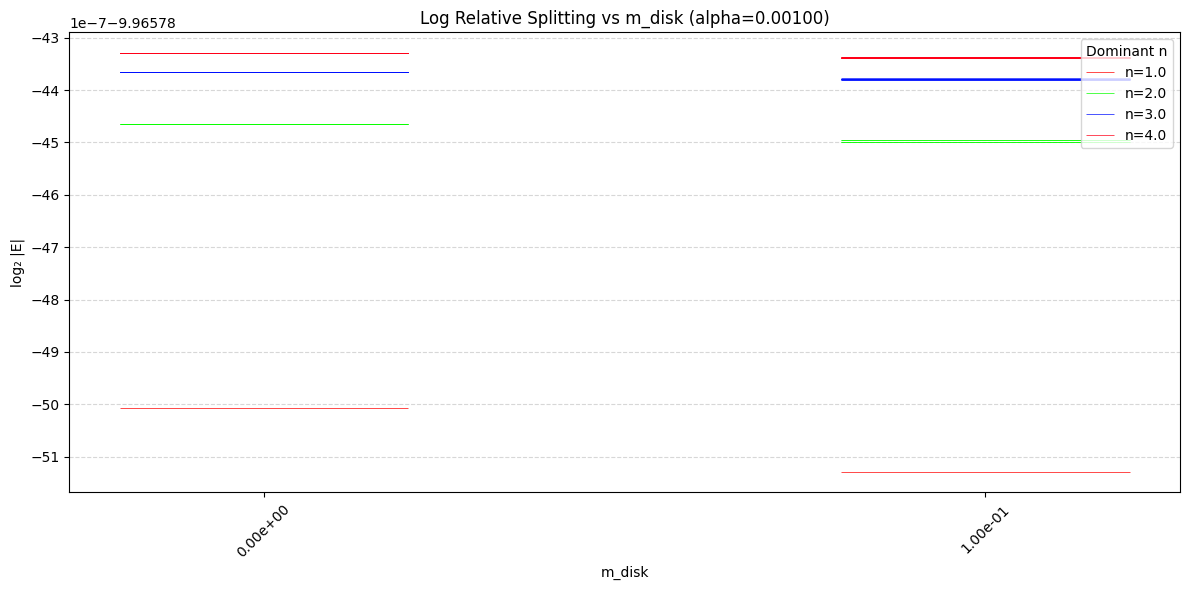

In [ ]:
m_disk_values = np.linspace(0,0.1,2)
max_levels = 24

plot_splitting_vs_mdisk_dominant_n(basis, N_max, m_disk_values, alpha,a,b, max_levels,a_0)